In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import constants, iceberg, metocean, drift, tools, simulator, test_case, plot, timesteppers

In [3]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

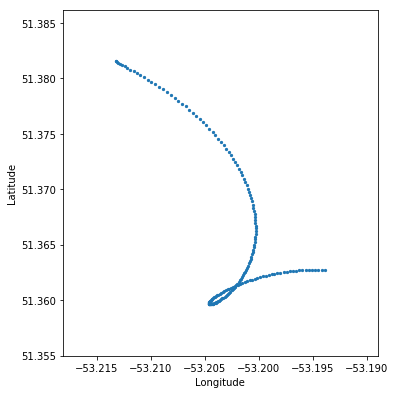

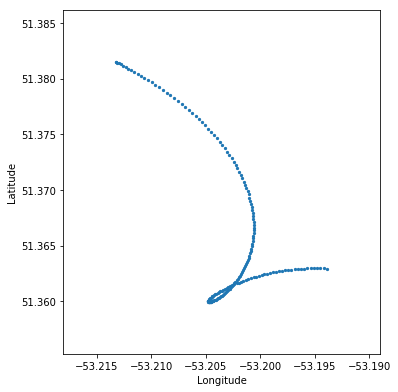

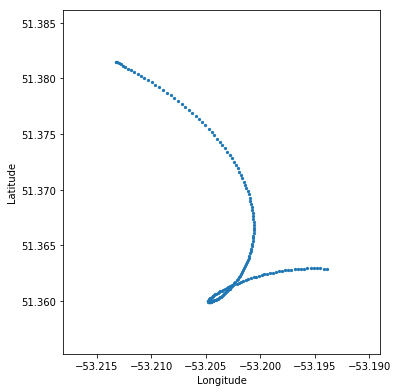

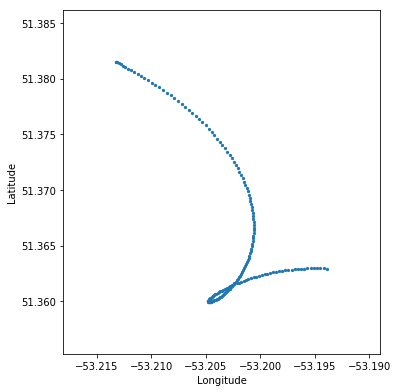

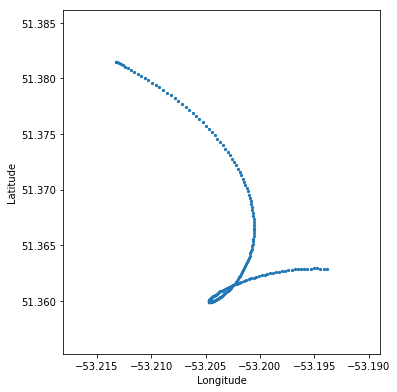

In [4]:
sim = simulator.Simulator()

sim.time_stepper = timesteppers.euler
sim.run_simulation(start_location, time_frame, store_results_as='euler')
plot.plot_iceberg_track(sim.results['euler']['latitude'], sim.results['euler']['longitude'])

sim.time_stepper = timesteppers.rk2
sim.run_simulation(start_location, time_frame, store_results_as='rk2')
plot.plot_iceberg_track(sim.results['rk2']['latitude'], sim.results['rk2']['longitude'])

sim.time_stepper = timesteppers.rk4
sim.run_simulation(start_location, time_frame, store_results_as='rk4')
plot.plot_iceberg_track(sim.results['rk4']['latitude'], sim.results['rk4']['longitude'])

sim.time_stepper = timesteppers.ab2
sim.run_simulation(start_location, time_frame, store_results_as='ab2')
plot.plot_iceberg_track(sim.results['ab2']['latitude'], sim.results['ab2']['longitude'])

sim.time_stepper = timesteppers.ab3
sim.run_simulation(start_location, time_frame, store_results_as='ab3')
plot.plot_iceberg_track(sim.results['ab3']['latitude'], sim.results['ab3']['longitude'])


# Optimization

In [5]:
from scipy import optimize

## Basinhopping

In [6]:
def sim_wrapper(x0, keys, start_location, time_frame, ref_latlons, **kwargs):
    
    print(x0)
    
    sim = simulator.Simulator()
    
    for i in range(len(x0)):
        
        kwargs[keys[i]] = x0[i]
        
    xds = sim.run_simulation(start_location, time_frame, **kwargs)
    
    mse = simulator.compute_mse((xds['latitude'], xds['longitude']), ref_latlons)
    
    return mse

In [7]:
class MyTakeStep(object):
    def __init__(self, stepsize=0.5):
        self.stepsize = stepsize
    def __call__(self, x):
        s = self.stepsize
        for i in range(len(x)):
            x[i] += np.random.uniform(0, s)
        return x
    
class MyBounds(object):
    def __init__(self, xmax=[1600, 600], xmin=[160, 60]):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs['x_new']
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax, tmin

In [8]:
x0 = 160, 60
keys = 'waterline_length', 'sail_height'
ref_latlons = ref_lats, ref_lons
args = keys, start_location, time_frame, ref_latlons
minimizer_kwargs = {'args': args}

In [9]:
optimization_result = optimize.basinhopping(sim_wrapper, x0, niter=10, interval=1,
                                            minimizer_kwargs=minimizer_kwargs, disp=True,
                                           take_step=MyTakeStep(100), accept_test=MyBounds())

[160.  60.]
[160.00000001  60.        ]
[160.          60.00000001]
[160.  60.]
basinhopping step 0: f 0.0117383
adaptive stepsize: acceptance rate 0.000000 target 0.500000 new stepsize 90 old stepsize 100
[225.6976609  130.69421994]
[225.69766092 130.69421994]
[225.6976609  130.69421996]
[225.6976609  130.69421994]
basinhopping step 1: f 0.011499 trial_f 0.011499 accepted 1  lowest_f 0.011499
found new global minimum on step 1 with function value 0.011499
adaptive stepsize: acceptance rate 0.500000 target 0.500000 new stepsize 81 old stepsize 90
[264.12371852 201.58153365]
[264.12371853 201.58153365]
[264.12371852 201.58153367]
[264.12371852 201.58153365]
basinhopping step 2: f 0.011509 trial_f 0.011509 accepted 1  lowest_f 0.011499
adaptive stepsize: acceptance rate 0.666667 target 0.500000 new stepsize 90 old stepsize 81
[316.90222377 237.5043665 ]
[316.90222379 237.5043665 ]
[316.90222377 237.50436652]
[316.90222377 237.5043665 ]
basinhopping step 3: f 0.0116024 trial_f 0.0116024 a

In [10]:
optimization_result

                        fun: 0.011499001837086575
 lowest_optimization_result:       fun: 0.011499001837086575
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-1.2019882e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([225.6976609 , 130.69421994])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 44
                        nit: 10
                       njev: 11
                          x: array([225.6976609 , 130.69421994])

## Differential Evolution

In [11]:
bounds = ((16, 1600), (6, 600))
optimization_result = optimize.differential_evolution(sim_wrapper, bounds, args)

[1596.2806723   251.20189851]
[261.9381763  135.64448231]
[1390.41875326  471.16902584]
[1231.28930775  403.50344306]
[1492.7979414   176.64046672]
[770.55162204 376.84313219]
[1157.06812741   45.45247239]
[998.71756825 401.58761729]
[519.83806521 502.32982643]
[1073.28957624  211.81702776]
[1522.0987399    19.50983722]
[440.86474905 162.87919817]
[181.20092971 577.08390033]
[856.99776133 288.90595275]
[1033.71910239   55.60204267]
[355.43221999 539.92147359]
[722.52770386 425.91222758]
[430.19112793 199.24431245]
[1316.93074477   93.24981938]
[325.88000611 241.18721007]
[700.86078193 593.75045637]
[1370.1569457   335.70401546]
[875.21776367 554.31993343]
[927.95520414 491.10109757]
[168.08358094  75.39398072]
[ 83.9767911  272.48164253]
[579.23657949 359.42757012]
[1222.41034453  305.95627736]
[ 23.62330232 114.42661697]
[609.6397881  461.11533353]
[672.20925293 166.54075081]
[913.98072153  49.26988133]
[373.11318139 224.03992189]
[308.53455736  23.54188058]
[1492.7979414    36.204538

In [12]:
optimization_result

     fun: 0.011494115844799114
 message: 'Optimization terminated successfully.'
    nfev: 183
     nit: 5
 success: True
       x: array([237.8434965 , 408.04831675])

# Fixing Quivers

In [13]:
import importlib

In [14]:
importlib.reload(plot)

<module 'icedef.plot' from '/home/evankielley/IceDEF/icedef/plot.py'>

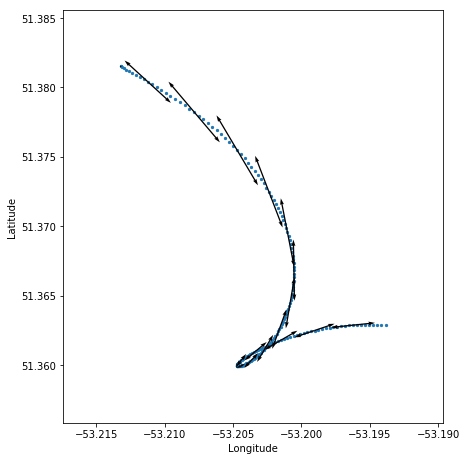

In [15]:
plot.plot_iceberg_track(sim.results['ab3']['latitude'], sim.results['ab3']['longitude'], 
    vectors=np.array([
    np.array([sim.results['ab3']['iceberg_eastward_velocity'].values, 
             sim.results['ab3']['iceberg_northward_velocity'].values]),
    np.array([sim.results['ab3']['iceberg_eastward_velocity'].values * -3, 
             sim.results['ab3']['iceberg_northward_velocity'].values * -3])
    ]), figure_scale_factor=1.2)

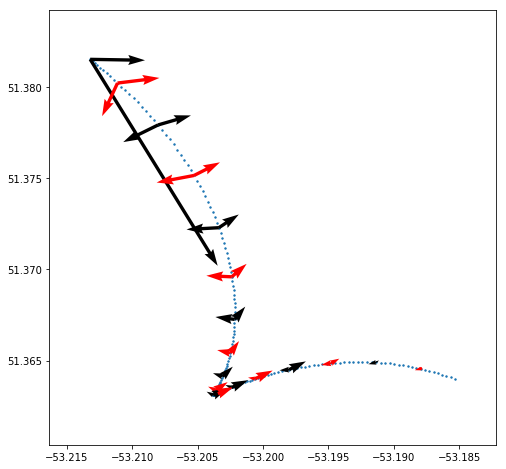

In [16]:
xds = simulator.run_test_simulation(start_location, time_frame)

gap = 10

X = np.array((xds['longitude'].values[::gap], xds['longitude'].values[::gap]))
Y = np.array((xds['latitude'].values[::gap], xds['latitude'].values[::gap]))
#X = xds['longitude'].values[::gap]
#Y = xds['latitude'].values[::gap]
U = np.array((xds['current_eastward_force'].values[::gap], xds['wind_eastward_force'].values[::gap]))
V = np.array((xds['current_northward_force'].values[::gap], xds['wind_northward_force'].values[::gap]))
C = ['black', 'red']

plt.figure(figsize=(8, 8))
plt.scatter(xds['longitude'], xds['latitude'], s=2)

plt.quiver(X, Y, U, V, color=C)

plt.show()

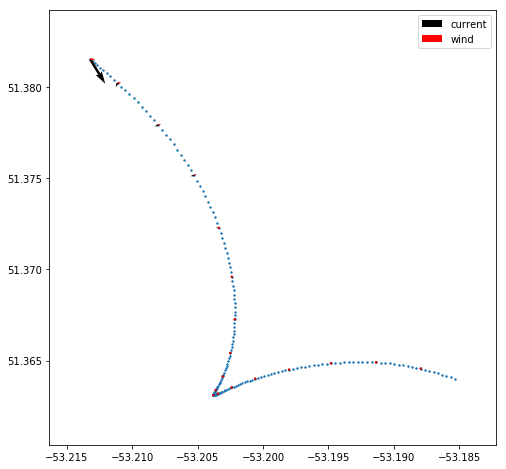

In [18]:
xds = simulator.run_test_simulation(start_location, time_frame)

gap = 10

X = xds['longitude'].values[::gap]
Y = xds['latitude'].values[::gap]
U = np.array((xds['current_eastward_force'].values[::gap], xds['wind_eastward_force'].values[::gap]))
V = np.array((xds['current_northward_force'].values[::gap], xds['wind_northward_force'].values[::gap]))
colors = ['black', 'red']
labels = ['current', 'wind']

plot_width = 8
plot_height = 8
plt.figure(figsize=(plot_width, plot_height))


plt.scatter(xds['longitude'], xds['latitude'], s=2, label=None)

norms = [np.linalg.norm(np.sqrt(u**2 + v**2)) for u, v in zip(U, V)]
mean_norm = np.mean(norms)

for u, v, color, label in zip(U, V, colors, labels):
    plt.quiver(X, Y, u, v, color=color, scale_units='xy', scale=mean_norm*800, 
               headwidth=8/4 * 1.4, width=4e-3 * 1.4, label=label)

plt.legend()
plt.show()

In [19]:
def plot_iceberg_track(x, y, **kwargs):

    if isinstance(x, xr.core.dataarray.DataArray): x = x.values
    if isinstance(y, xr.core.dataarray.DataArray): y = y.values
    
    show = kwargs.pop('show', True)
    save = kwargs.pop('save', False)
    filename = kwargs.pop('filename', 'plot')

    plot_width = kwargs.pop('plot_width', 12)
    plot_height = kwargs.pop('plot_height', 12)
    autoscale_figure = kwargs.pop('autoscale_figure', True)
    figure_scale = kwargs.pop('figure_scale', 1)

    if autoscale_figure:
        len_x_values = abs(max(x) - min(x))
        len_y_values = abs(max(y) - min(y))
        plot_width = plot_width * (len_x_values / (len_x_values + len_y_values))
        plot_height = plot_height * (len_y_values / (len_x_values + len_y_values))

    plot_width *= figure_scale
    plot_height *= figure_scale
    
    plt.figure(figsize=(plot_width, plot_height))

    xlabel = kwargs.pop('xlabel', 'Longitude')
    ylabel = kwargs.pop('ylabel', 'Latitude')
    title = kwargs.pop('title', '')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    gap = kwargs.pop('gap', 10)
    track_marker_size = kwargs.pop('track_marker_size', 5)
    ref_marker_size = kwargs.pop('ref_marker_size', 5)
    arrow_scale = kwargs.pop('arrow_scale', 1)
    width_scale = kwargs.pop('width_scale', 1)
    headwidth_scale = kwargs.pop('headwidth_scale', 1)
    arrow_shaftwidth = kwargs.pop('arrow_shaftwidth', 0.0005 * plot_width)
    arrow_headlength = kwargs.pop('arrow_headlength', 5)
    arrow_headwidth = kwargs.pop('arrow_headwidth', 3)
    colors = kwargs.pop('colors', ['black'] * 10)
    labels = kwargs.pop('labels', [''] * 10)
    ref_track = kwargs.pop('ref_track', None)
    quiver_ref_track = kwargs.pop('quiver_ref_track', False)

    plt.scatter(x, y, s=track_marker_size, label='')
        
        
    # QUIVER
    
    U = kwargs.pop('U', None); V = kwargs.pop('V', None)
    
    if U is not None and V is not None:
        for u, v in zip(U, V):
            
            if isinstance(u, xr.core.dataarray.DataArray): u = u.values
            if isinstance(v, xr.core.dataarray.DataArray): v = v.values
    
    mean_norm = np.mean([np.linalg.norm(np.sqrt(u**2 + v**2)) for u, v in zip(U, V)])
    
    for u, v, color, label in zip(U, V, colors, labels):
        plt.quiver(x[::gap], y[::gap], u[::gap], v[::gap], 
                   scale_units='xy', 
                   scale=mean_norm * np.sqrt(plot_width**2 + plot_height**2) * 100 * arrow_scale, 
                   color=color, 
                   label=label,
                   headwidth=8/4 * headwidth_scale, 
                   width=4e-3 * width_scale)  


    # INCOMPLETE
    plt.legend()
    plt.show()
                
                
#     if vectors is not None:

#         i = 0

#         for vector_u, vector_v in vectors:

#             if isinstance(vector_u, xr.core.dataarray.DataArray):
#                 vector_u = vector_u.values

#             if isinstance(vector_v, xr.core.dataarray.DataArray):
#                 vector_v = vector_v.values

#             plt.quiver(lons[::gap], lats[::gap], vector_u[::gap], vector_v[::gap],
#                        scale=arrow_scale, width=arrow_shaftwidth, headlength=arrow_headlength,
#                        headwidth=arrow_headwidth, color=arrow_colors[i], label=arrow_labels[i])
#             i += 1

#         if ref_track is not None:

#             ref_lats, ref_lons = ref_track
#             plt.scatter(ref_lons, ref_lats, s=ref_marker_size, label='')
#             plt.plot(ref_lons, ref_lats)

#             if quiver_ref_track:

#                 ref_lat_list = []
#                 ref_lon_list = []

#                 for i in np.arange(0, len(vector_u), gap):
#                     ref_lat_list.append(ref_lats.interp(time=vector_u.time[i]))
#                     ref_lon_list.append(ref_lons.interp(time=vector_u.time[i]))

#                 i = 0

#                 for vector_u, vector_v in vectors:
#                     plt.quiver(ref_lon_list, ref_lat_list, vector_u[::gap], vector_v[::gap],
#                                scale=arrow_scale, width=arrow_shaftwidth, headlength=arrow_headlength,
#                                headwidth=arrow_headwidth, color=arrow_colors[i], label='')
#                     i += 1

#         if arrow_labels[0] is not '':
#             plt.legend()

#     if save:
#         plt.savefig(f'{filename}.png')

#     if show:
#         plt.show()

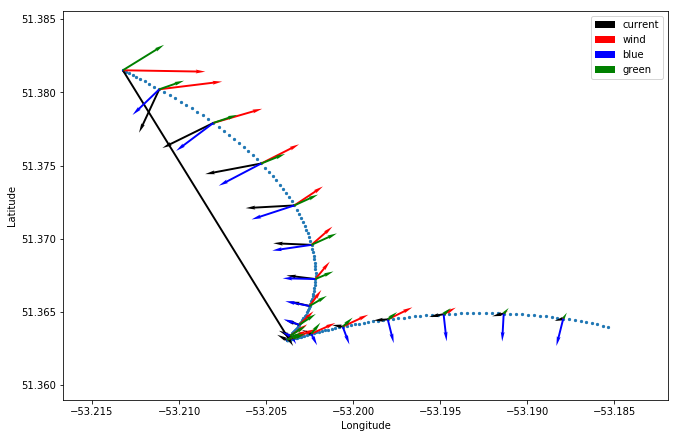

In [20]:
plot_iceberg_track(xds['longitude'], xds['latitude'],
                  U=[
                      xds['current_eastward_force'], xds['wind_eastward_force'],
                      xds['coriolis_eastward_force'], xds['pressure_eastward_force']
                  ],
                  V=[
                      xds['current_northward_force'], xds['wind_northward_force'],
                      xds['coriolis_northward_force'], xds['pressure_northward_force']
                  ],
                  colors=['black', 'red', 'blue', 'green'],
                  labels=['current', 'wind', 'blue', 'green'],
                  arrow_scale=0.03,
                   width_scale=0.8,
                  figure_scale=1.5)

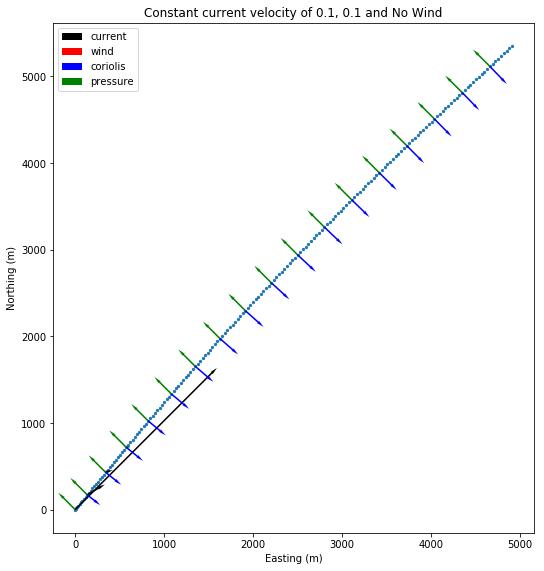

In [21]:
xds = simulator.run_test_simulation(start_location, time_frame,
                                   constant_current_velocity=(0.1, 0.1),
                                   constant_wind_velocity=(0, 0))


plot_iceberg_track(xds['easting'], xds['northing'],
                  U=[
                      xds['current_eastward_force'], xds['wind_eastward_force'],
                      xds['coriolis_eastward_force'], xds['pressure_eastward_force']
                  ],
                  V=[
                      xds['current_northward_force'], xds['wind_northward_force'],
                      xds['coriolis_northward_force'], xds['pressure_northward_force']
                  ],
                  colors=['black', 'red', 'blue', 'green'],
                  labels=['current', 'wind', 'coriolis', 'pressure'],
                  arrow_scale=3e-7,
                   width_scale=0.8,
                  figure_scale=1.5,
                  title='Constant current velocity of 0.1, 0.1 and No Wind',
                  xlabel='Easting (m)',
                  ylabel='Northing (m)')

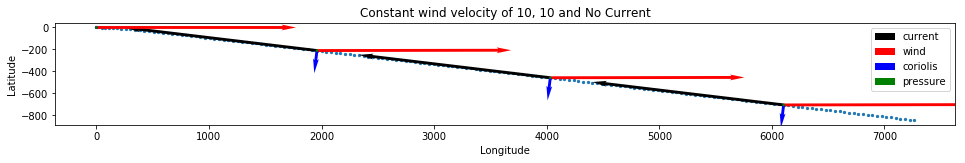

In [25]:
xds = simulator.run_test_simulation(start_location, time_frame,
                                   constant_current_velocity=(0, 0),
                                   constant_wind_velocity=(10, 0))


plot_iceberg_track(xds['easting'], xds['northing'],
                  U=[
                      xds['current_eastward_force'], xds['wind_eastward_force'],
                      xds['coriolis_eastward_force'], xds['pressure_eastward_force']
                  ],
                  V=[
                      xds['current_northward_force'], xds['wind_northward_force'],
                      xds['coriolis_northward_force'], xds['pressure_northward_force']
                  ],
                  colors=['black', 'red', 'blue', 'green'],
                  labels=['current', 'wind', 'coriolis', 'pressure'],
                  arrow_scale=0.51e-7,
                   width_scale=0.8,
                  figure_scale=1.5,
                   gap=50,
                  title='Constant wind velocity of 10, 10 and No Current')

# Water Pressure Gradient Force Derivation

$$\frac{\partial u}{\partial t} = - \frac{1}{\rho} \frac{\partial P}{\partial x} + fv$$
$$\frac{\partial v}{\partial t} = - \frac{1}{\rho} \frac{\partial P}{\partial y} - fu$$

$$\frac{\partial P}{\partial x} =  \rho(fv - \frac{\partial u}{\partial t})$$
$$\frac{\partial P}{\partial y} =  \rho(-fu - \frac{\partial v}{\partial t})$$

$$F_{px} = PLH - (P + \frac{\partial P}{\partial x}L)LH$$
$$F_{py} = PLH - (P + \frac{\partial P}{\partial y}L)LH$$

$$F_{px} = -L^2H \frac{\partial P}{\partial x}$$
$$F_{py} = -L^2H \frac{\partial P}{\partial y}$$

$$F_{px} = \rho L^2 H (\frac{\partial u}{\partial t} - fv)$$
$$F_{py} = \rho L^2 H (\frac{\partial v}{\partial t} + fu)$$

$$F_{px} = M (\frac{\partial u}{\partial t} - fv)$$
$$F_{py} = M (\frac{\partial v}{\partial t} + fu)$$